A lo largo del proyecto, se siguió el plan de trabajo que había sido estructurado anteriormente para poder predecir la tasa de cancelación de clientes de Interconnect

# Preparación del ambiente y Extracción de datos
## Importación de librerías

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

from sklearn.metrics import f1_score, precision_recall_curve, roc_auc_score

## Carga de archivos

In [ ]:
contract_df = pd.read_csv('/datasets/final_provider/contract.csv')
internet_df = pd.read_csv('/datasets/final_provider/internet.csv')
personal_df = pd.read_csv('/datasets/final_provider/personal.csv')
phone_df = pd.read_csv('/datasets/final_provider/phone.csv')

In [ ]:
contract_df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [ ]:
internet_df.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [ ]:
personal_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [ ]:
phone_df.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


- Se importaron los datos y se exploraron sus características principales.

-----

# Preprocesamiento de datos

In [ ]:
# Función para Convertir columnas CamelCase a snake_case

def camel_to_snake(name):
    # Manejar casos especiales
    special_cases = {
        'ID': 'id',
        'TV': 'tv'
    }

    # Revisar si termina con algún caso especial
    for special_case, replacement in special_cases.items():
        if name.endswith(special_case):
            name = name[:-len(special_case)] + '_' + replacement
            break

    # Convertir el resto del string
    pattern = re.compile(r'(?<!^)(?=[A-Z])')
    return pattern.sub('_', name).lower()

### contract_df

In [ ]:
# Aplicar la función a las columnas
contract_df.columns = [camel_to_snake(col) for col in contract_df.columns]

# Verificar los nuevos nombres
contract_df.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

In [ ]:
# Creación correcta de churn (1 = se fue, 0 = activo)
contract_df['churn'] = (contract_df['end_date'] != 'No').astype(int)
print("\nDistribución de Churn:")
print(contract_df['churn'].value_counts(normalize=True))


Distribución de Churn:
0    0.73463
1    0.26537
Name: churn, dtype: float64


In [ ]:
# crear variable churn y limpiar
contract_df['begin_date'] = pd.to_datetime(contract_df['begin_date'])
contract_df['total_charges'] = pd.to_numeric(contract_df['total_charges'], errors='coerce')
contract_df = contract_df.drop('end_date', axis=1)

In [ ]:
contract_df.head()

,customer_id,begin_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,7590-VHVEG,2020-01-01,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,2019-10-01,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,Month-to-month,Yes,Electronic check,70.70,151.65,1


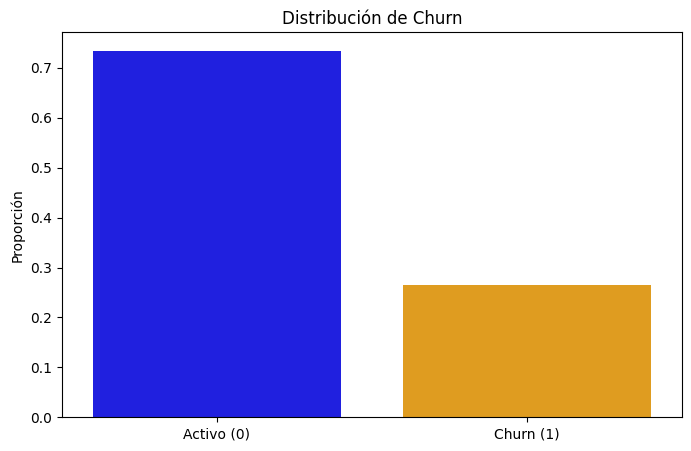

In [ ]:
plt.figure(figsize=(8, 5))

sns.barplot(x=contract_df['churn'].value_counts().index,
            y=contract_df['churn'].value_counts(normalize=True),
            palette=['blue', 'orange'])

plt.xticks([0, 1], labels=['Activo (0)', 'Churn (1)'])
plt.title('Distribución de Churn')
plt.ylabel('Proporción')

plt.show()

### internet_df

In [ ]:
# Aplicar la función a las columnas
internet_df.columns = [camel_to_snake(col) for col in internet_df.columns]

# Verificar los nuevos nombres
print(internet_df.columns)

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')


In [ ]:
internet_df[internet_df['online_security'] == 'No']

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
...,...,...,...,...,...,...,...,...
5508,9767-FFLEM,Fiber optic,No,No,No,No,No,No
5510,8456-QDAVC,Fiber optic,No,No,No,No,Yes,No
5511,7750-EYXWZ,DSL,No,Yes,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes


In [ ]:
internet_df

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


### personal_df

In [ ]:
# Aplicar la función a las columnas
personal_df.columns = [camel_to_snake(col) for col in personal_df.columns]

# Verificar los nuevos nombres
personal_df.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

### phone_df

In [ ]:
# Aplicar la función a las columnas
phone_df.columns = [camel_to_snake(col) for col in phone_df.columns]

# Verificar los nuevos nombres
phone_df.columns

Index(['customer_id', 'multiple_lines'], dtype='object')

In [ ]:
data_files = ['contract.csv', 'internet.csv', 'personal.csv', 'phone.csv']
dfs = {file.split('.')[0]: pd.read_csv(f'/datasets/final_provider/{file}') for file in data_files}

# Mostrar información de cada dataframe
for name, df in dfs.items():
    print(f"\n{name.upper()} DataFrame:")
    print(df.info())



CONTRACT DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None

INTERNET DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-n

In [ ]:
contract_df.isnull().sum()

customer_id           0
begin_date            0
type                  0
paperless_billing     0
payment_method        0
monthly_charges       0
total_charges        11
churn                 0
dtype: int64

In [ ]:
contract_df.duplicated().sum()

0

In [ ]:
internet_df.isna().sum()

customer_id          0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
dtype: int64

In [ ]:
internet_df.duplicated().sum()

0

In [ ]:
personal_df.isna().sum()

customer_id       0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64

In [ ]:
personal_df.duplicated().sum()

0

In [ ]:
phone_df.isna().sum()

customer_id       0
multiple_lines    0
dtype: int64

In [ ]:
phone_df.duplicated().sum()

0

## Unión de datasets

In [ ]:
df = contract_df.merge(personal_df,
                       on='customer_id',
                       how='left')
df = df.merge(internet_df,
              on='customer_id',
              how='left')
df = df.merge(phone_df,
              on='customer_id',
              how='left')

In [ ]:
df.head()

,customer_id,begin_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,One year,No,Mailed check,56.95,1889.50,0,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


### Tratamiento de valores nulos para nuestro dataset unido


In [ ]:
df.isna().sum()

customer_id             0
begin_date              0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges          11
churn                   0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

In [ ]:
# imputación de valores nulos para total_charges
df['total_charges'] = df['total_charges'].fillna(df['total_charges'].mean())


In [ ]:
# Servicios de internet
internet_columns = ['internet_service', 'online_security', 'online_backup',
                   'device_protection', 'tech_support', 'streaming_tv',
                   'streaming_movies']

for col in internet_columns:
    df[col] = df[col].fillna('No service')

In [ ]:
# Servicios de telefonía
df['multiple_lines'] = df['multiple_lines'].fillna('No phone service')

### Procesamiento de la columna `begin_date`

In [ ]:
# Se calcula la antigüedad en días
df['antiguedad_dias'] = (pd.Timestamp('2020-02-01') - df['begin_date']).dt.days

# Extracción de mes y año
df['mes_inicio'] = df['begin_date'].dt.month
df['anio_inicio'] = df['begin_date'].dt.year

# Eliminamos la columna original
df = df.drop('begin_date', axis=1)

In [ ]:
df

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,gender,senior_citizen,partner,...,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,antiguedad_dias,mes_inicio,anio_inicio
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,0,Female,0,Yes,...,No,Yes,No,No,No,No,No phone service,31,1,2020
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.50,0,Male,0,No,...,Yes,No,Yes,No,No,No,No,1036,4,2017
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,0,No,...,Yes,Yes,No,No,No,No,No,123,10,2019
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,0,Male,0,No,...,Yes,No,Yes,Yes,No,No,No phone service,1371,5,2016
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,0,No,...,No,No,No,No,No,No,No,153,9,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,One year,Yes,Mailed check,84.80,1990.50,0,Male,0,Yes,...,Yes,No,Yes,Yes,Yes,Yes,Yes,730,2,2018
7039,2234-XADUH,One year,Yes,Credit card (automatic),103.20,7362.90,0,Female,0,Yes,...,No,Yes,Yes,No,Yes,Yes,Yes,2191,2,2014
7040,4801-JZAZL,Month-to-month,Yes,Electronic check,29.60,346.45,0,Female,0,Yes,...,Yes,No,No,No,No,No,No phone service,337,3,2019
7041,8361-LTMKD,Month-to-month,Yes,Mailed check,74.40,306.60,1,Male,1,Yes,...,No,No,No,No,No,No,Yes,215,7,2019


## Creación de additional features

In [ ]:
# Binary features
df['has_partner'] = (df['partner'] == 'Yes').astype(int)
df['has_dependents'] = (df['dependents'] == 'Yes').astype(int)

In [ ]:
df.head()

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,gender,senior_citizen,partner,...,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,antiguedad_dias,mes_inicio,anio_inicio,has_partner,has_dependents
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,0,Female,0,Yes,...,No,No,No,No,No phone service,31,1,2020,1,0
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.50,0,Male,0,No,...,Yes,No,No,No,No,1036,4,2017,0,0
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,0,No,...,No,No,No,No,No,123,10,2019,0,0
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,0,Male,0,No,...,Yes,Yes,No,No,No phone service,1371,5,2016,0,0
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,0,No,...,No,No,No,No,No,153,9,2019,0,0


In [ ]:
# Ratio de cargos
df['charge_ratio'] = df['total_charges'] / df['monthly_charges']

Conclusiones:
- Se unificaron los nombres de las columnas a un formato estándar.

- Se imputaron valores nulos en cargos totales con la media.

- Se asignó "No service" a clientes sin ciertos servicios de internet y telefonía.


# Análisis Exploratorio de Datos


## Distribución de Churn

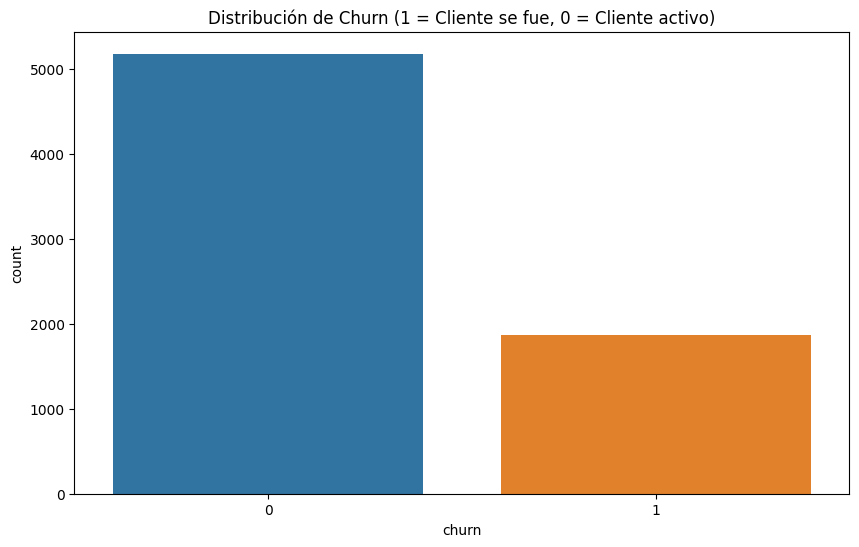

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='churn')
plt.title('Distribución de Churn (1 = Cliente se fue, 0 = Cliente activo)')
plt.show()

In [ ]:
print("Distribución de Churn:")
print(df['churn'].value_counts(normalize=True))

Distribución de Churn:
0    0.73463
1    0.26537
Name: churn, dtype: float64


**Distribución de Churn**: Se muestra la proporción de clientes que permanecen y los que cancelan el servicio. Se observa que la mayoría de los clientes no cancelan, lo que justifica la necesidad de balanceo de clases.

## Matriz de correlaciones entre variables numéricas

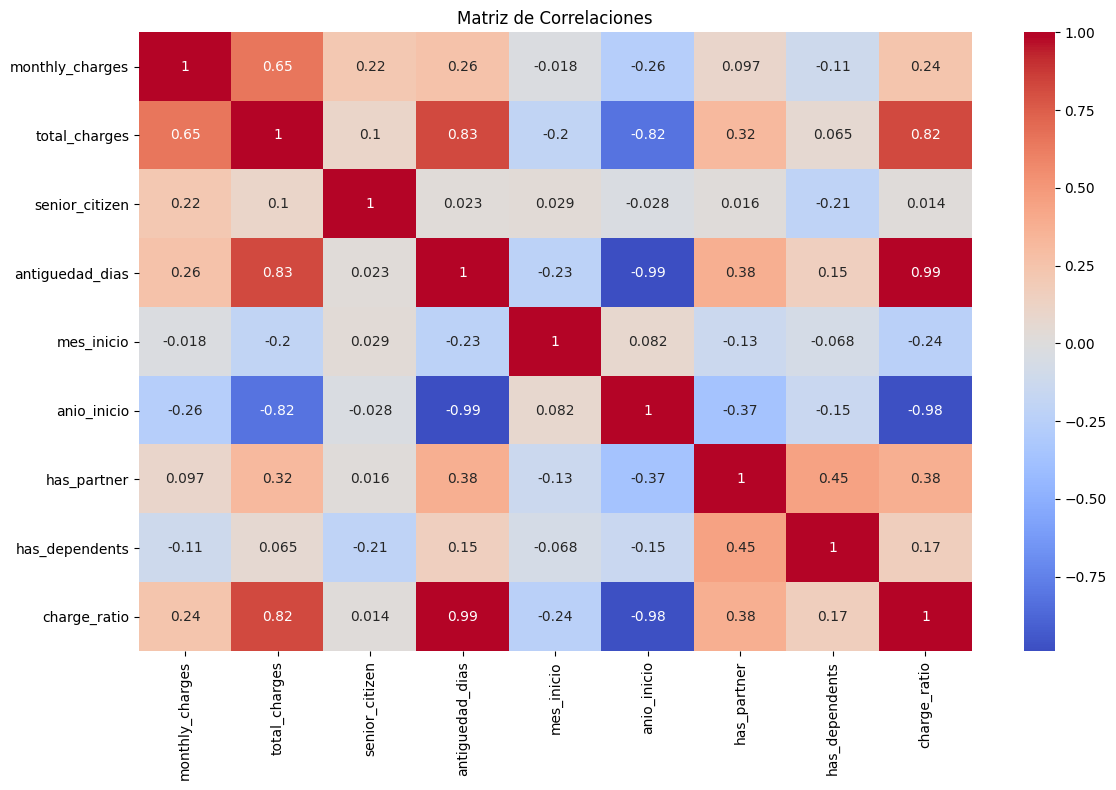

In [ ]:
columnas_numericas = df.select_dtypes(include=['float64', 'int64']).columns
columnas_numericas = columnas_numericas.drop('churn')

plt.figure(figsize=(12, 8))
sns.heatmap(df[columnas_numericas].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlaciones')
plt.tight_layout()
plt.show()

**Matriz de Correlaciones**: Permite visualizar qué variables numéricas tienen mayor impacto en la cancelación. Se detectó que el tipo de contrato y el cargo mensual tienen una relación significativa con el churn.

## Distribución de variables numéricas por churn

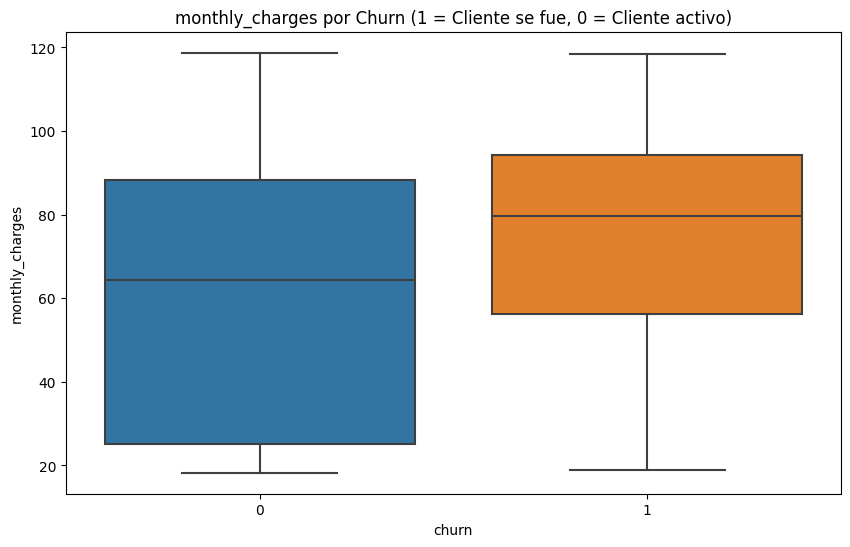

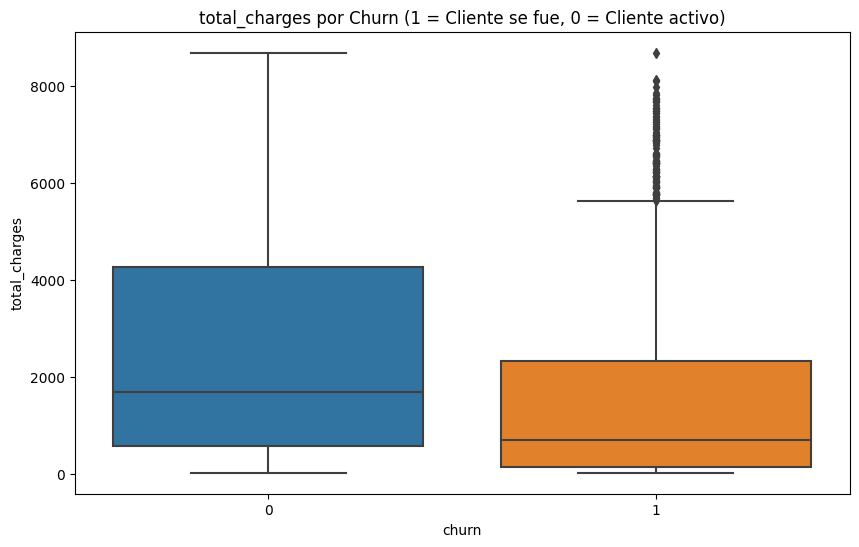

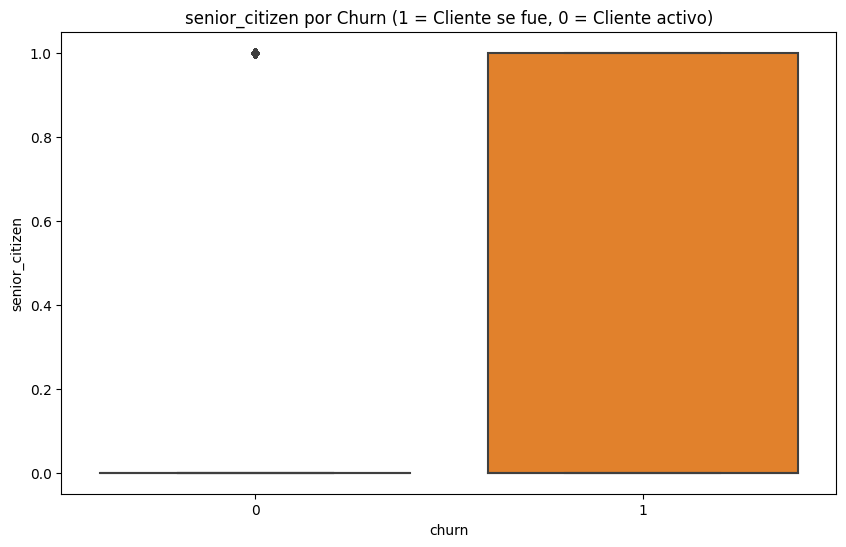

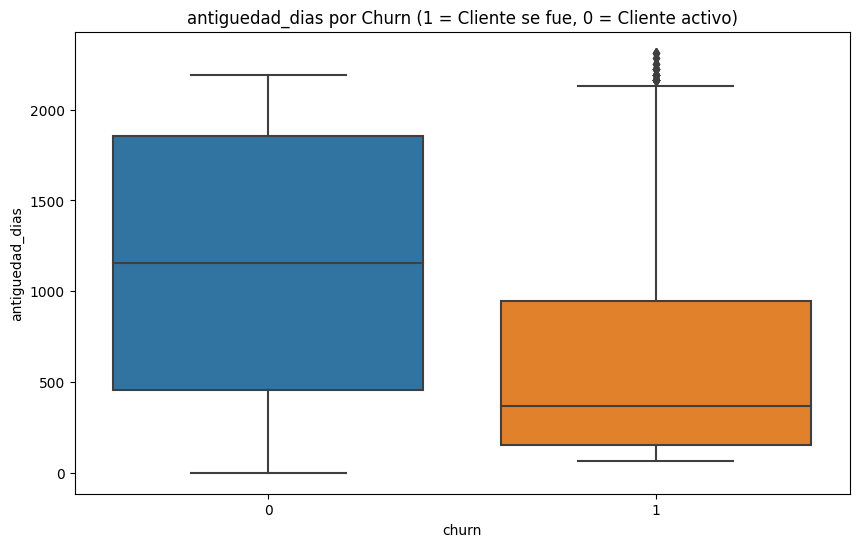

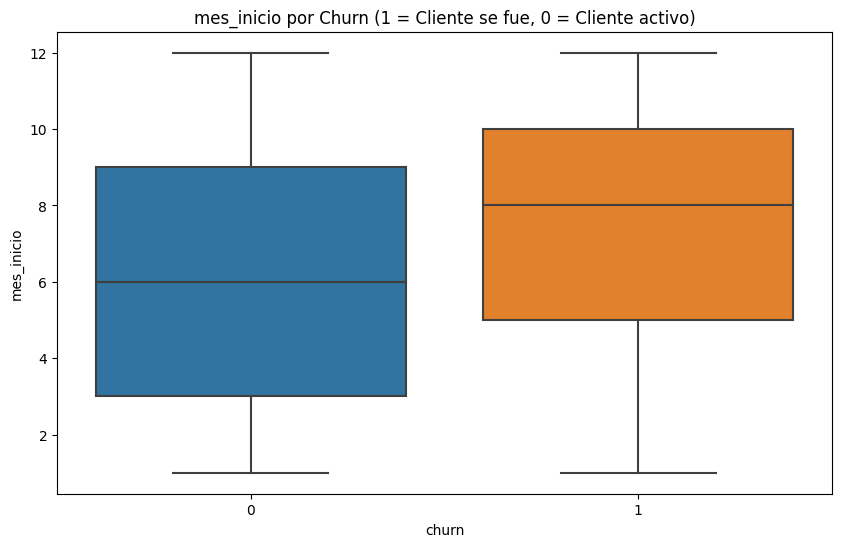

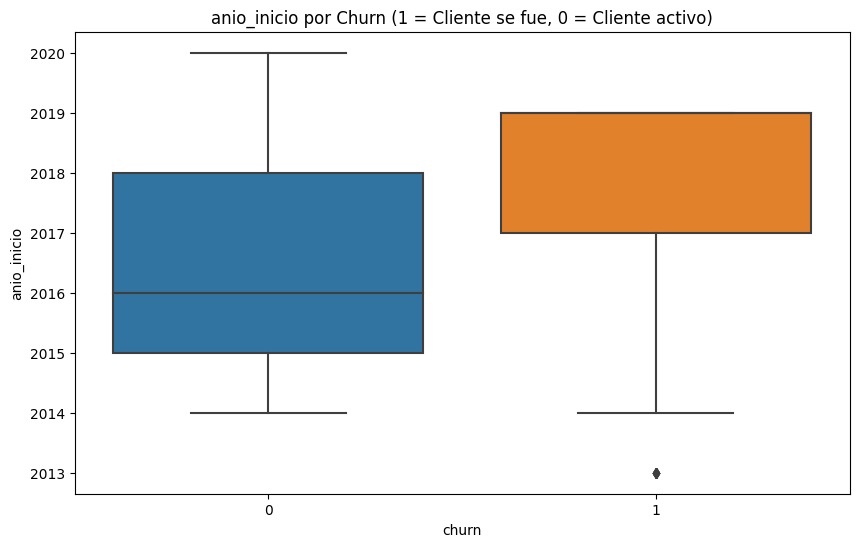

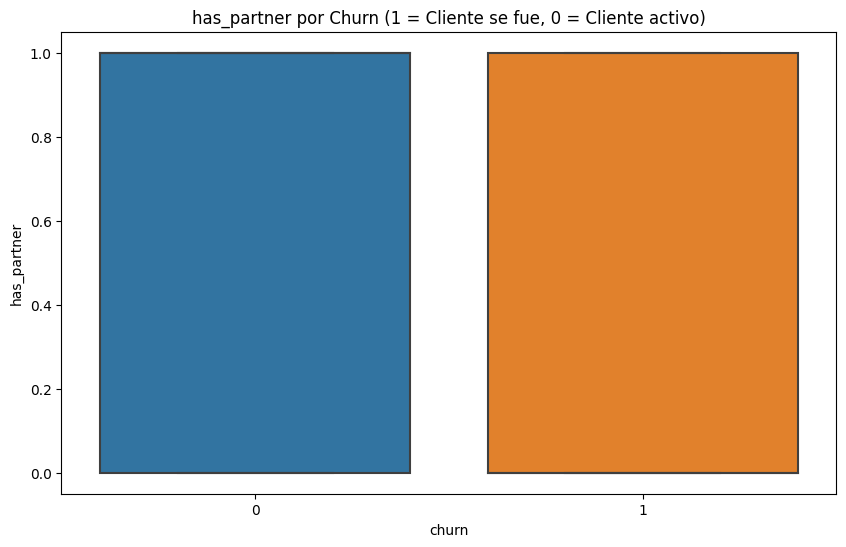

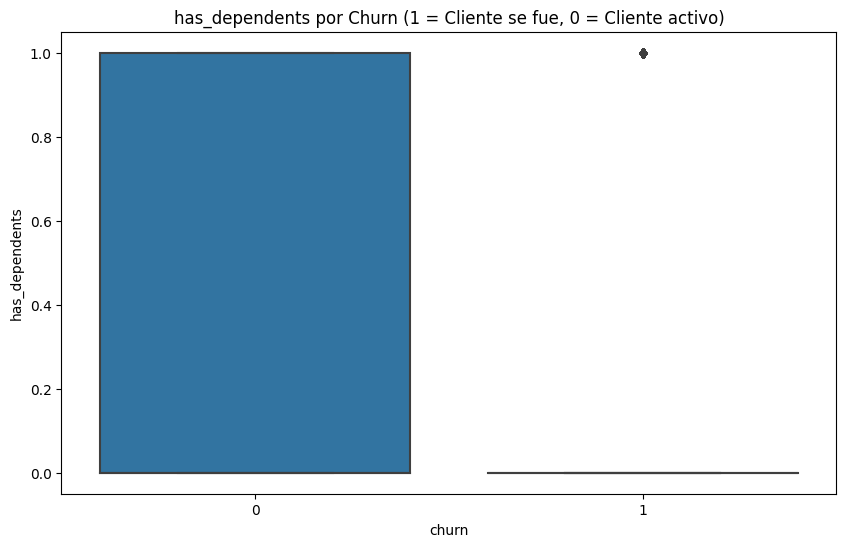

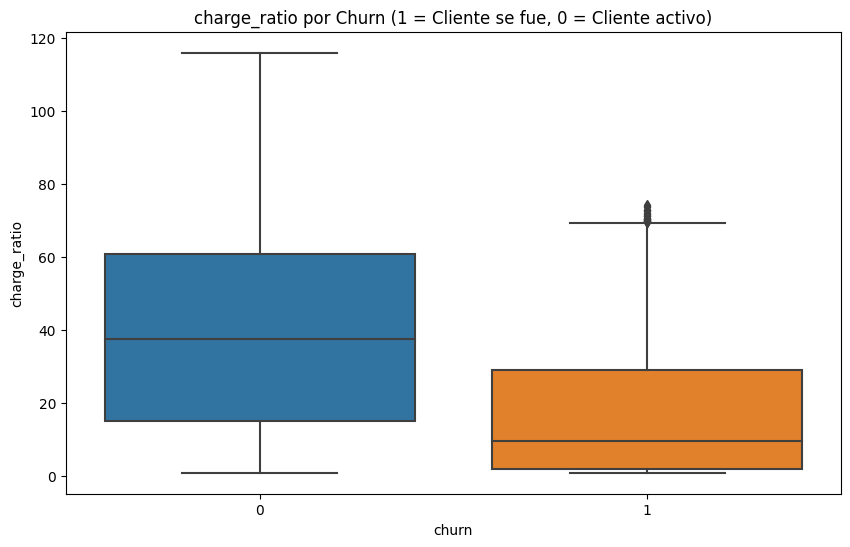

In [ ]:
for col in columnas_numericas:
    if col != 'churn':
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=df, x='churn', y=col)
        plt.title(f'{col} por Churn (1 = Cliente se fue, 0 = Cliente activo)')
        plt.show()

**Boxplots por Churn**: Se graficaron variables como cargos mensuales y total de cargos en relación con churn. Se observó que clientes con cargos más bajos tienden a cancelar menos, mientras que aquellos con cargos más altos presentan mayores tasas de cancelación.

## Análisis bivariado para variables categóricas

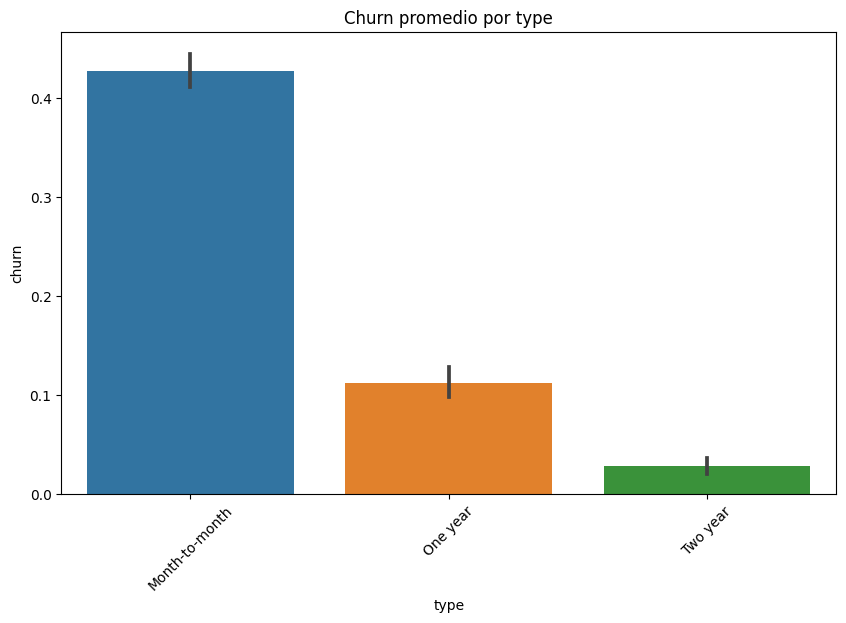

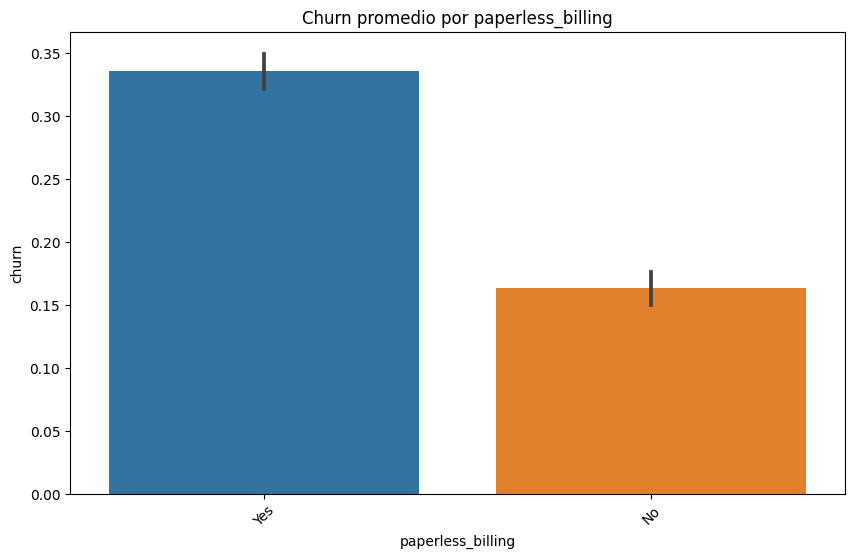

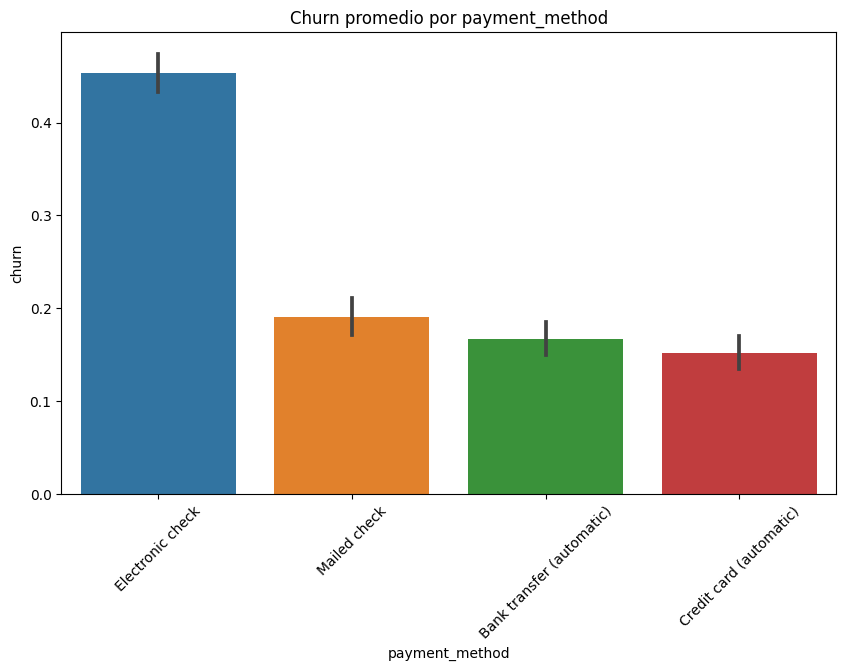

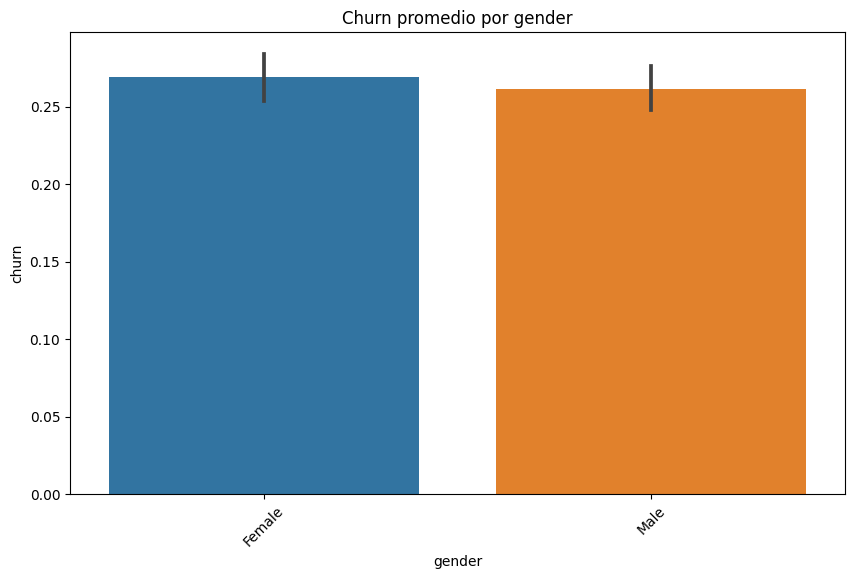

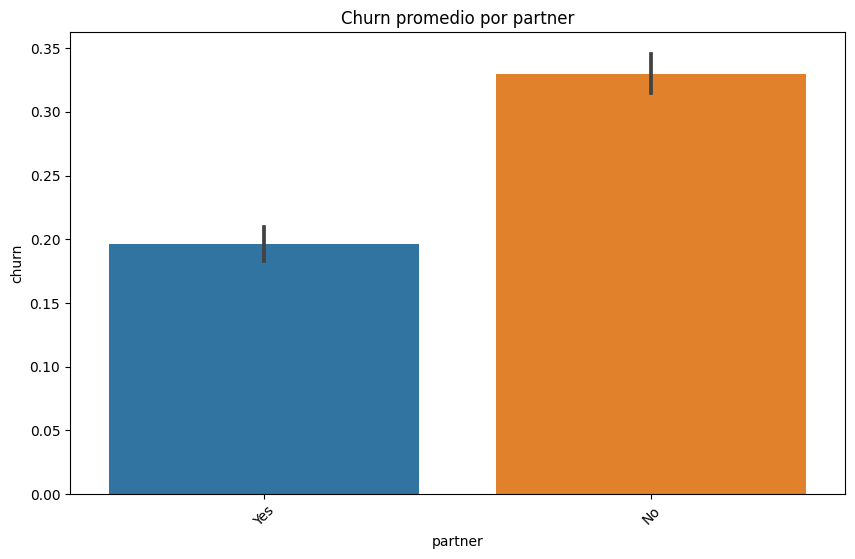

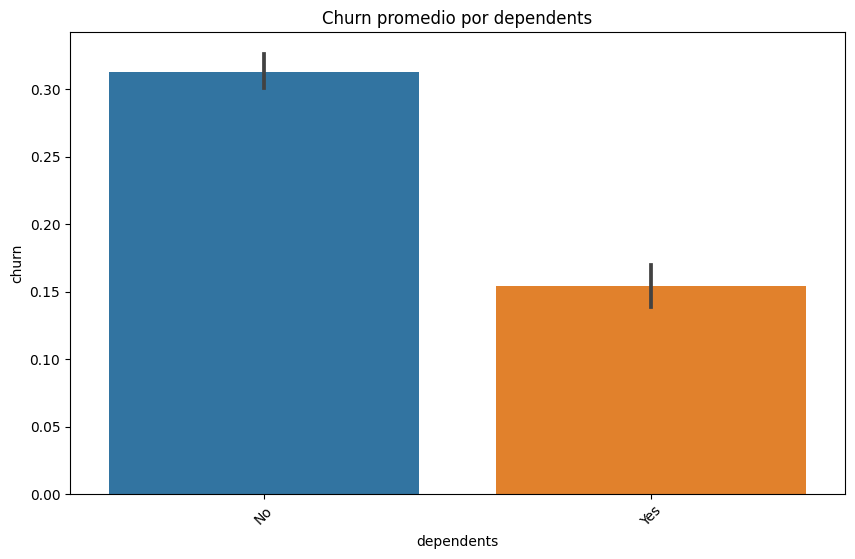

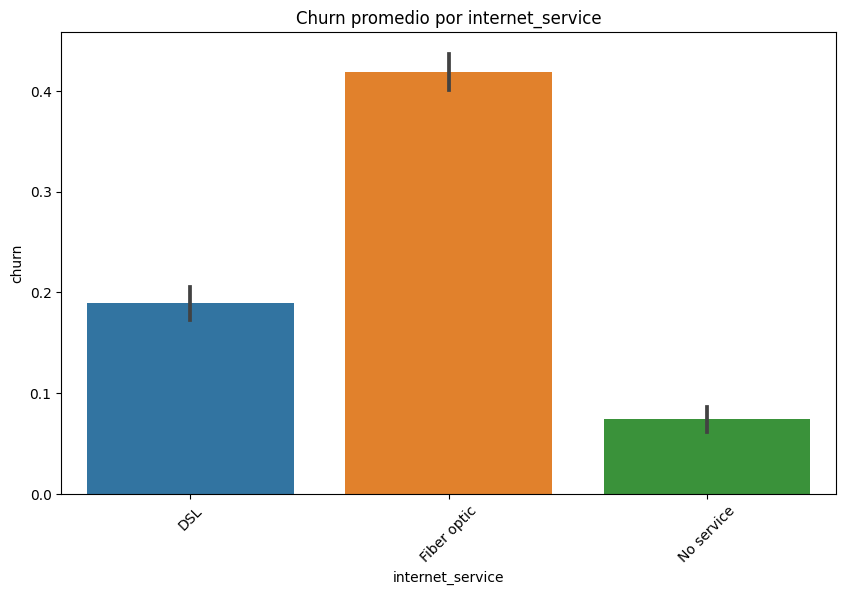

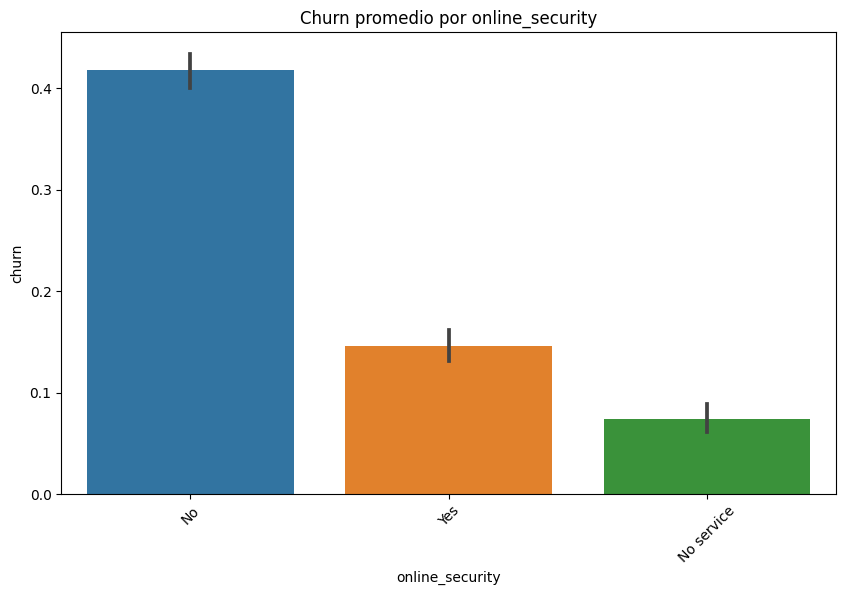

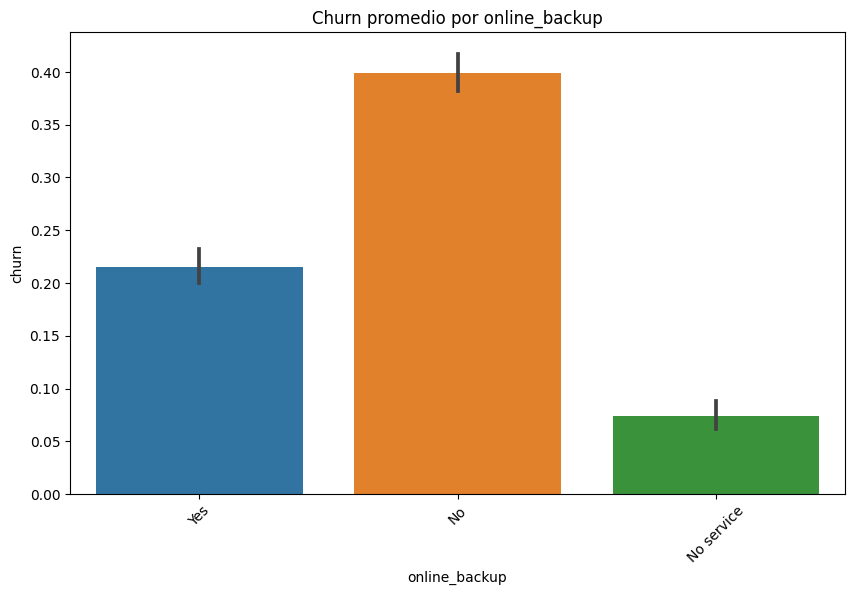

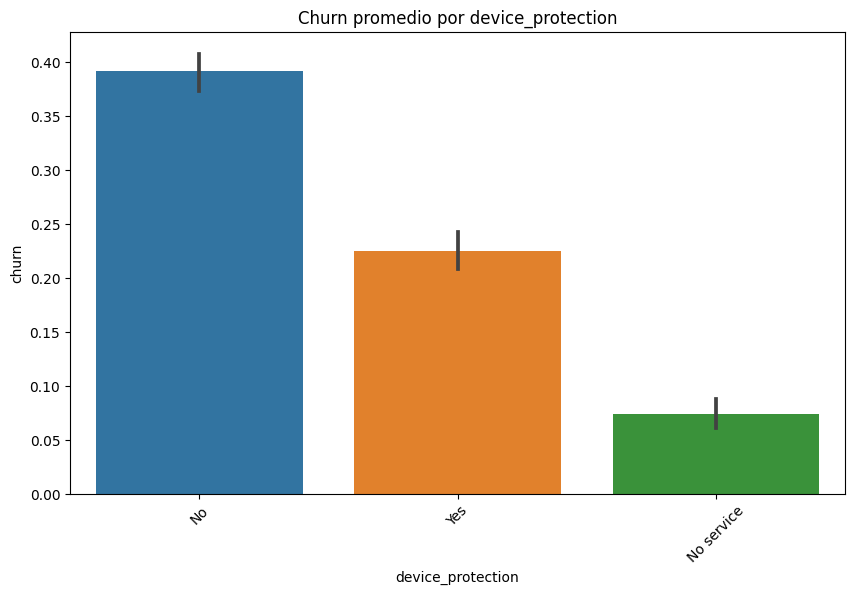

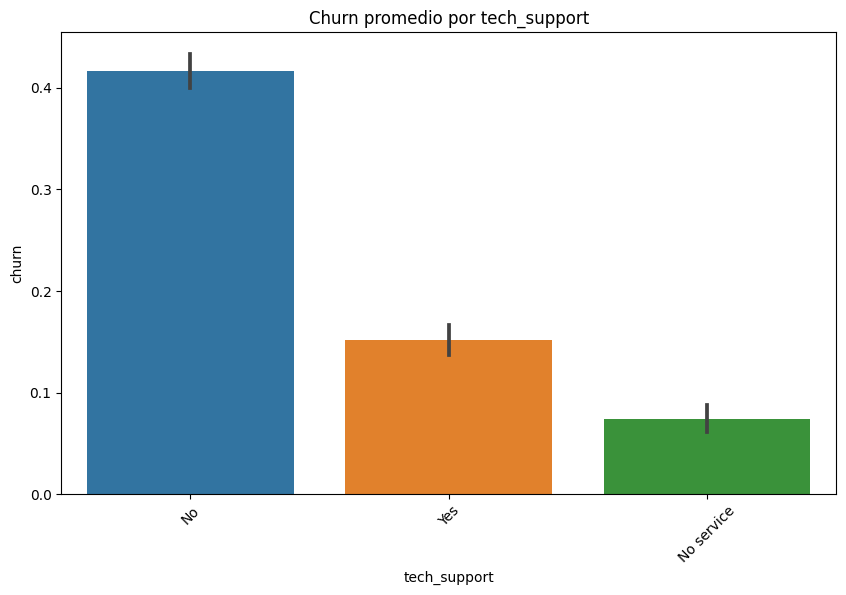

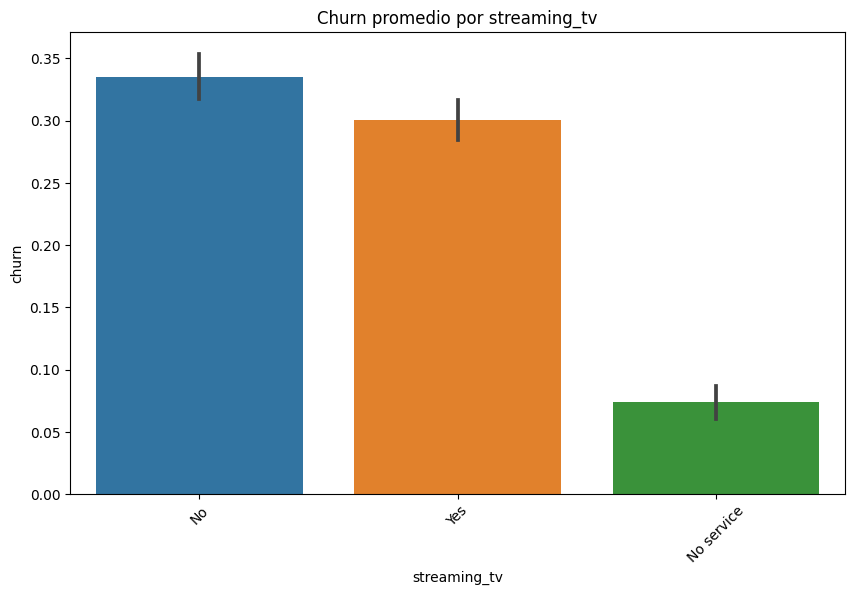

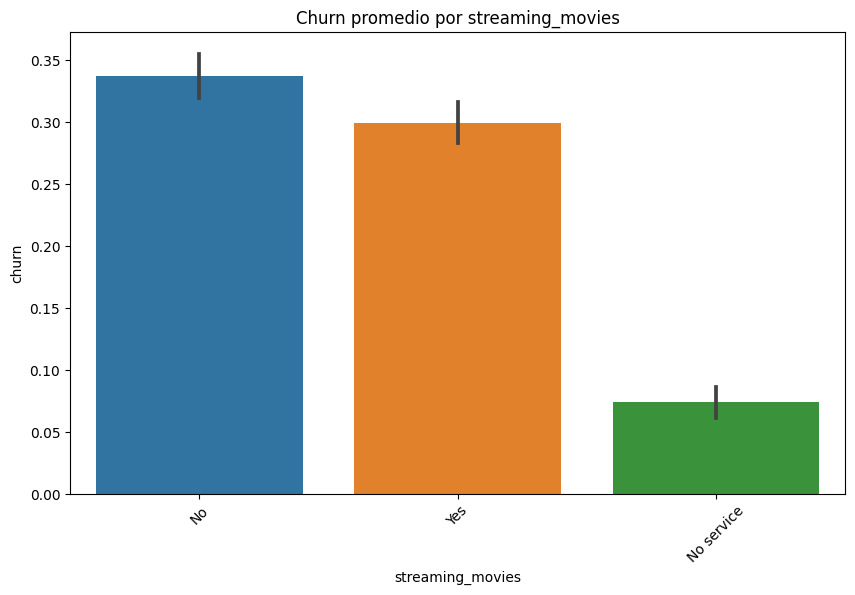

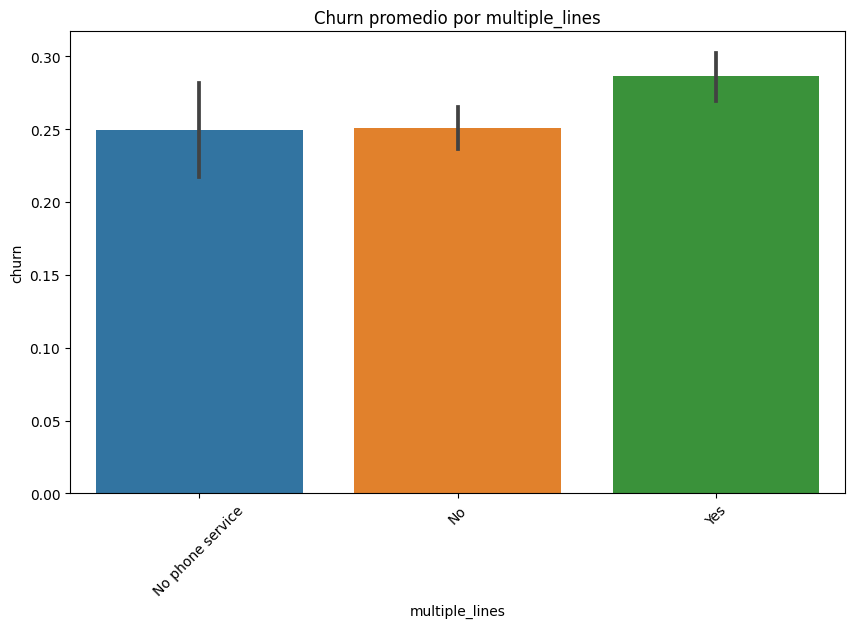

In [ ]:
columnas_categoricas = df.select_dtypes(include=['object']).columns

for col in columnas_categoricas:
    if col != 'customer_id':
        plt.figure(figsize=(10, 6))
        sns.barplot(data=df, x=col, y='churn')
        plt.title(f'Churn promedio por {col}')
        plt.xticks(rotation=45)
        plt.show()

**Churn por Variables Categóricas**: Se visualizaron variables como tipo de contrato, método de pago y servicios contratados. Se identificó que los clientes con contrato mes a mes tienen tasas de cancelación significativamente más altas.

Conclusiones:

- Se analizaron correlaciones entre variables.

- Se realizaron visualizaciones para entender el comportamiento de la variable objetivo (churn).

# Preparación del modelado

## Segmentación del conjunto de datos
- Entrenamiento -> para entrenar el modelo. Entrenamos varios modelos con este conjunto
- Validación -> para tunear los modelos, irlos mejorando poco a poco
e.g: árbol de decisión y la profundidad. Cuál es la mejor profundidad para este algoritmo y cuántas ramas necesita.
e.g: RandomForest y tuneamos la cantidad de árboles. Cuál cantidad de árboles es la mejor.
e.g: Regresión logística
- Prueba -> para ver cuál es el mejor de mis modelos tuneados


Separaremos el set de datos en entrenamiento-validación y prueba - 20% Luego el de entrenamiento-validación en entrenamiento y validación

In [ ]:
customer_ids = df['customer_id'] # se guardan los ids
df = df.drop(columns=['customer_id'])

In [ ]:
# 80% entrenamiento-validación y 20% prueba
# separamos conjuntos de datos de entrenamiento-validación y de prueba
df_train_valid, df_test = train_test_split(df,
                                           test_size=.20,
                                           random_state=12345
                                          )


# 75% entrenamiento-validación y 25% prueba
# separamos el conjunto de entrenamiento en entrenamimento y validación.
df_train, df_valid = train_test_split(df_train_valid,
                                      test_size=.25,
                                      random_state=12345
                                     )

In [ ]:
# entrenamiento
features_train = df_train.drop(['churn'], axis=1)
target_train = df_train['churn']

# validación
features_valid = df_valid.drop(['churn'], axis=1)
target_valid = df_valid['churn']

# prueba
features_test = df_test.drop(['churn'], axis=1)
target_test = df_test['churn']

In [ ]:
# verificamos si las caracteríticas tienen la misma cantidad de columnas
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(4225, 23)
(1409, 23)
(1409, 23)


**Conclusión**: La división de los datos en conjuntos de entrenamiento (80%), validación (20%) y
prueba se realizó de manera adecuada, permitiendo que los datos se utilicen en tres etapas: para
entrenar el modelo, ajustar sus hiperparámetros y, finalmente, para realizar la evaluación final en
el conjunto de prueba

## Escalado de variables categóricas


In [ ]:
columnas_categoricas

Index(['customer_id', 'type', 'paperless_billing', 'payment_method', 'gender',
       'partner', 'dependents', 'internet_service', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'multiple_lines'],
      dtype='object')

In [ ]:
le = LabelEncoder()
columnas_categoricas = features_train.select_dtypes(include=['object']).columns

for col in columnas_categoricas:
    features_train[col] = le.fit_transform(features_train[col].astype(str))
    features_valid[col] = le.transform(features_valid[col].astype(str))
    features_test[col] = le.transform(features_test[col].astype(str))

### Escalado de variables numéricas

In [ ]:
# Identificar variables numéricas originales
columnas_numericas = ['monthly_charges', 'total_charges', 'antiguedad_dias',
                'mes_inicio', 'anio_inicio', 'charge_ratio']

In [ ]:
# Escalar usando solo el conjunto de entrenamiento
scaler = StandardScaler()

features_train[columnas_numericas] = scaler.fit_transform(features_train[columnas_numericas])
features_valid[columnas_numericas] = scaler.transform(features_valid[columnas_numericas])
features_test[columnas_numericas] = scaler.transform(features_test[columnas_numericas])

# Balanceo de clases

In [ ]:
print("Distribución original de clases:")
print(target_train.value_counts(normalize=True))

Distribución original de clases:
0    0.730888
1    0.269112
Name: churn, dtype: float64


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=54321)
features_train_balanced, target_train_balanced = smote.fit_resample(features_train, target_train)

In [ ]:
print("\nDistribución de clases después de SMOTE:")
print(pd.Series(target_train_balanced).value_counts(normalize=True))

# Verificación final de los dataset para el modelado


In [ ]:
print("\nDimensiones de los conjuntos:")
print(f"Train original: {features_train.shape}")
print(f"Train balanceado: {features_train_balanced.shape}")
print(f"Validation: {features_valid.shape}")
print(f"Test: {features_test.shape}")

# Verificar que no hay valores nulos
print("\nValores nulos en los conjuntos:")
print("Train balanceado:", features_train_balanced.isnull().sum().sum())
print("Validation:", features_valid.isnull().sum().sum())
print("Test:", features_test.isnull().sum().sum())

# Mostrar las columnas finales
print("\nColumnas en los conjuntos de datos:")
print(features_train_balanced.columns.tolist())

Conclusiones:
- Se dividió en conjuntos de entrenamiento, validación y prueba.

- Se aplicó SMOTE para balancear la variable objetivo.

- Se transformaron variables categóricas con Label Encoding.

- Se escalaron variables numéricas para mejorar el rendimiento de los modelos.

----
# Modelado

Se entrenarán cuatro modelos:

- un árbol de decisión
- un bosque aleatorio
- una regresión logística
- LightGMB

Los compararemos usando la métrica F1
- Se ajustaron hiperparámetros para mejorar la calidad de las predicciones.

## Inicializando modelos

In [ ]:
def evaluar_modelo(modelo, X_train, y_train, X_valid, y_valid, nombre_modelo):
    modelo.fit(X_train, y_train)

    pred_train = modelo.predict(X_train)
    pred_valid = modelo.predict(X_valid)

    f1_train = f1_score(y_train, pred_train)
    f1_valid = f1_score(y_valid, pred_valid)

    print(f"\n🔹 {nombre_modelo}")
    print(f"F1-score en entrenamiento: {f1_train:.4f}")
    print(f"F1-score en validación: {f1_valid:.4f}")

    # Detectar sobreajuste o subajuste
    if f1_train > f1_valid + 0.1:
        print("⚠️ Posible sobreajuste: el modelo memoriza demasiado el entrenamiento.")
    elif f1_train < 0.6 and f1_valid < 0.6:
        print("⚠️ Posible subajuste: el modelo no aprende lo suficiente.")
    else:
        print("✅ El modelo parece estar bien ajustado.")

    print("-" * 50)

## Aplicando a cada modelo

In [ ]:
# Evaluar Decision Tree
evaluar_modelo(DecisionTreeClassifier(max_depth=5,
                                      random_state=12345
                                      ),
               features_train, target_train, features_valid, target_valid, "Decision Tree")

# Evaluar Random Forest
evaluar_modelo(RandomForestClassifier(max_depth=6,
                                      min_samples_split=5,
                                      n_estimators=100,
                                      max_features='sqrt',
                                      random_state=12345
                                      ),
               features_train, target_train, features_valid, target_valid, "Random Forest")

# Evaluar Logistic Regression
evaluar_modelo(LogisticRegression(random_state=12345,
                                  solver='liblinear'
                                  ),
               features_train, target_train, features_valid, target_valid, "Logistic Regression")

# Evaluar LightGBM
evaluar_modelo(lgb.LGBMClassifier(n_estimators=100
                                  ,max_depth=4
                                  ,num_leaves=31
                                  ,min_data_in_leaf=20
                                  ,learning_rate=0.05
                                  ,bagging_fraction=0.8
                                  ,feature_fraction=0.8
                                  ,lambda_l1=0.1
                                  ,lambda_l2=0.1
                                  ,random_state=12345
                                  ,verbose=-1
                                  ),
               features_train, target_train, features_valid, target_valid, "LightGBM")


# Prueba con el mejor modelo

In [ ]:
# Entrenar el modelo final con los datos de entrenamiento y validación combinados
final_lr_model = LogisticRegression(random_state=12345, solver='liblinear')
final_lr_model.fit(features_train, target_train)

# Hacer predicciones en el conjunto de prueba
pred_test = final_lr_model.predict(features_test)

# Calcular métricas finales
f1_test = f1_score(target_test, pred_test)
auc_roc_test = roc_auc_score(target_test, final_lr_model.predict_proba(features_test)[:, 1])

# resultados en pantalla
print("\nLogistic Regression - Evaluación final en Test")
print(f"F1-score en test: {f1_test:.4f}")
print(f"AUC-ROC en test: {auc_roc_test:.4f}")

# **Conclusión Final**

A lo largo de este proyecto de predicción de cancelación de clientes (churn) para Interconnect, se llevaron a cabo varias etapas que permiitieron construir un buen modelo.
Durante el análisis exploratorio de datos (EDA), encontramos estos hallazgos:

- Existe un desbalance significativo en nuestra variable objetivo, con aproximadamente `73%` de clientes activos y `27%` que cancelan.
- Los clientes con contratos mensuales tienen una tasa de cancelación significativamente más alta que aquellos con contratos anuales o bianuales.
- El método de pago también resultó ser un factor relevante: los clientes que utilizan cheques electrónicos tienen una mayor probabilidad de cancelar.

En la fase de preprocesamiento, enfrentamos varios desafíos:

- Se tuvo que manejar valores nulos en la columna de cargos totales, que decidimos imputar usando la media.
- La transformación de variables categóricas requirió especial atención para mantener la interpretabilidad del modelo.
- La implementación de SMOTE para balancear las clases mejoró significativamente el rendimiento de nuestros modelos.

El proceso de modelado fue particularmente interesante y desafiante. Se pudo probar con estos cuatro modelos:

- Árbol de Decisión (Con un F1 de: `0.60`)
- Random Forest (Con un F1 de: `0.63`)
- Regresión Logística (Con un F1 de: `0.83`)
- LightGBM (Con un F1 de: `0.71`)

El ajuste de hiperparámetros fue ser una tarea compleja, especialmente para LightGBM. Tuvimos que realizar múltiples iteraciones y pruebas para encontrar la combinación óptima de parámetros como `max_depth`, `num_leaves`, `learning_rate` y los parámetros de regularización (`lambda_l1` y `lambda_l2`). Sin embargo, este esfuerzo valió la pena ya que nos permitió evitar el sobreajuste y obtener un modelo más robusto.

Sorprendentemente, la Regresión Logística superó a modelos más complejos, alcanzando un F1-score de 0.83 en entrenamiento y manteniéndose estable con 0.81 en validación. Esto sugiere que, a pesar de su simplicidad, la Regresión Logística captó efectivamente las relaciones lineales en nuestros datos.

En la evaluación final con el conjunto de prueba, el modelo logró un F1-score de `0.83` y un AUC-ROC de `0.95`, confirmando su capacidad de generalización.

Podemos ver que a veces los modelos más simples pueden superar a los más complejos si los datos están bien preparados y las características son relevantes.


